# Gift Recommender Engine: Topic Classification on Tweets

I will now test the models on some user's Twitter accounts and assess the performance of my classifier. There are two different datasets that I can use to test my model: 1) Company's Tweets - This can be used as a proof-of-concept baseline test of the approach. Companies should be very distinct (ex. ESPN should predict sports, etc), so it may give a picture if the classifier is going on the right approach. 2) Celebrity's Tweets - we have some understanding of what a celebrity may or may not like (whether they are a singer, actor, or athlete). This way, we can test how the model is doing on specific users. 3) Random users Tweets. Dataset on Kaggle containing Tweets for sentiment analysis. I filtered the tweets to that of users who have Tweeted more than 50 times. This is extremely messy data - not all Tweets are relevant to gifting.

In [92]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pickle

# Naive Bayes Model
filename = open('models/nb_baseline2.sav', 'rb')
nb = pickle.load(filename)

# Support Vector Classifier Model
filename = open('models/linear_svc_baseline2.sav', 'rb')
ovr_svc = pickle.load(filename)

# Import Vectorizer
filename = open('models/tfidf_vectorizer2.sav', 'rb')
tfidf_model = pickle.load(filename)

# Import Reference Dictionary
filename = open('models/reference-dict.pickle', 'rb')
ref = pickle.load(filename)

In [5]:
import re
import string
import nltk
import spacy
from nltk.probability import FreqDist

stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['im', "oh", "i'm", "lol", "gonna", 'ill'])
nlp = spacy.load('en_core_web_sm')

def spacy_lemmatize(text):
    if type(text) == list:
        doc = nlp(u"{}".format(' '.join(text)))
    else:
        doc = nlp(u"{}".format(text))
    lemmatized = list()
    for token in doc:
        lemmatized.append(token.lemma_)
    
    return lemmatized

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def preprocess(text):
    text=re.sub(r'http\S+', '',text)
    text = re.sub('@[^\s]+','',text)
    text = re.sub('&lt;/?[a-z]+&gt;', '', text)
    text = text.replace('&amp', '&')
    text = re.sub(r"[^\w\s]", "", text)
    text = deEmojify(text)
    text = text.split() #split into list
    #text = [re.sub(r'^https?:\/\/.*[\r\n]*', '', s, flags=re.MULTILINE) for s in text] #remove any links
    #text = [re.sub('@[^\s]+','', s) for s in text] #remove @
    text = [s.lower() for s in text] #convert every character into lowercase
    #text = [re.sub(rf"[{string.punctuation}]", " ", s) for s in text] #remove punctuations
    text = [re.sub(r'[0-9]', ' ', s) for s in text] #remove all digits
    text = ' '.join(text)  #resplits
    text = [s for s in text.split() if len(s) >= 2] #removes words with one word length
    text = [s for s in text if s not in stopwords] #remove all stopwords
    text = ' '.join(spacy_lemmatize(text)) #lemmatize text using spacy and join into a string
    text = ' '.join([s for s in text.split() if len(s) > 2])
    return text

## Company Tweets

### ESPN Tweets

In [6]:
import pandas as pd

espn = pd.read_csv('datasets/twitter-profiles/report_espn/tweets.csv')
espn.head()

,Tweet Id,Tweet URL,Tweet Posted Time,Tweet Content,Tweet Type,Client,Retweets received,Likes received,User Id,Name,Username,Verified or Non-Verified,Profile URL,Protected or Not Protected
0,"""1220229853557018625""",https://twitter.com/sportscenter/status/122022...,2020-01-23 06:20:42,"""“Coach, I can win the game for this team. Lea...",Retweet,Khoros,879,4845,"""26257166""","""SportsCenter""",sportscenter,Verified,https://twitter.com/sportscenter,Not Protected
1,"""1220226518712037376""",https://twitter.com/espn/status/12202265187120...,2020-01-23 06:07:27,"""Fans watching Zion go off in his first game 😮...",Tweet,Khoros,1682,8050,"""2557521""","""ESPN""",espn,Verified,https://twitter.com/espn,Not Protected
2,"""1220214633442746369""",https://twitter.com/sportsnation/status/122021...,2020-01-23 05:20:13,"""Zion Williamson: 1 career game, 4 three-point...",Retweet,Khoros,2879,14761,"""21254264""","""SportsNation""",sportsnation,Verified,https://twitter.com/sportsnation,Not Protected
3,"""1220212122849857538""",https://twitter.com/espn/status/12202121228498...,2020-01-23 05:10:15,"""Zion put on a show in his NBA debut 🔥 https:/...",Tweet,Khoros,1821,12816,"""2557521""","""ESPN""",espn,Verified,https://twitter.com/espn,Not Protected
4,"""1220208628751327232""",https://twitter.com/espn/status/12202086287513...,2020-01-23 04:56:22,"""ZION WENT OFF 😳\n\n17 points and 4/4 from dee...",Tweet,Khoros,3857,17229,"""2557521""","""ESPN""",espn,Verified,https://twitter.com/espn,Not Protected


In [7]:
espn_tweets = espn[espn['Tweet Type'] == 'Tweet']
espn_tweets['clean-tweet'] = espn_tweets['Tweet Content'].map(preprocess)

In [11]:
espn_data = espn_tweets[['Tweet Content', 'clean-tweet']].rename(columns={'Tweet Content': 'tweet'})

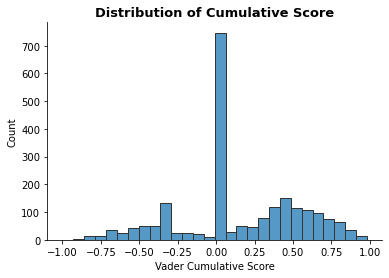

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
espn_data['vader-sentiment'] = espn_data['tweet'].apply(lambda x: analyzer.polarity_scores(x))
espn_data['vader-pos'] = espn_data['vader-sentiment'].apply(lambda x: x['pos'])
espn_data['vader-neu'] = espn_data['vader-sentiment'].apply(lambda x: x['neu'])
espn_data['vader-neg'] = espn_data['vader-sentiment'].apply(lambda x: x['neg'])
espn_data['vader-compound'] = espn_data['vader-sentiment'].apply(lambda x: x['compound'])

sns.histplot(espn_data['vader-compound'], edgecolor='.2')
plt.xlabel('Vader Cumulative Score')
plt.title('Distribution of Cumulative Score', fontweight='bold', fontsize=13)
sns.despine()
plt.show()

In [15]:
espn_filtered = espn_data[espn_data['vader-compound'] >= 0]
espn_filtered.shape

(1727, 7)

In [18]:
clean_tweets = espn_filtered['clean-tweet'].to_list()
nb_topic_pred = list()
svc_topic_pred = list()

for tweet in clean_tweets:
    nb_topic = ref[nb.predict(tfidf_model.transform([tweet]))[0]]
    nb_topic_pred.append(nb_topic)
    
    svc_topic = ref[ovr_svc.predict(tfidf_model.transform([tweet]))[0]]
    svc_topic_pred.append(svc_topic)

In [23]:
nb_series = pd.Series(nb_topic_pred).value_counts()[:3]
nb_series

Sports    1014
Books      155
Travel     125
dtype: int64

In [22]:
svc_series = pd.Series(svc_topic_pred).value_counts()[:3]
svc_series

Sports    988
Music     190
Gamers    108
dtype: int64

### Sports Center Tweets

In [25]:
sports_center = pd.read_csv('datasets/twitter-profiles/report_sportscenter/tweets.csv')
sports_center.head()

,Tweet Id,Tweet URL,Tweet Posted Time,Tweet Content,Tweet Type,Client,Retweets received,Likes received,User Id,Name,Username,Verified or Non-Verified,Profile URL,Protected or Not Protected
0,"""1220229853557018625""",https://twitter.com/sportscenter/status/122022...,2020-01-23 06:20:42,"""“Coach, I can win the game for this team. Lea...",Tweet,Khoros,876,4834,"""26257166""","""SportsCenter""",sportscenter,Verified,https://twitter.com/sportscenter,Not Protected
1,"""1220222069020991489""",https://twitter.com/sportscenter/status/122022...,2020-01-23 05:49:46,"""⚡️ 22 Pts\n⚡️ 8-11 FG\n⚡️ 4-4 3-PT FG\n⚡️ 7 R...",Tweet,Twitter Media Studio,1649,10240,"""26257166""","""SportsCenter""",sportscenter,Verified,https://twitter.com/sportscenter,Not Protected
2,"""1220206449479028737""",https://twitter.com/sportscenter/status/122020...,2020-01-23 04:47:42,"""ZION IS TAKING OVER 🔥\n\n17 STRAIGHT 😱 https:...",Tweet,Khoros,4595,25871,"""26257166""","""SportsCenter""",sportscenter,Verified,https://twitter.com/sportscenter,Not Protected
3,"""1220200064896970752""",https://twitter.com/sportscenter/status/122020...,2020-01-23 04:22:20,"""LeBron was asked about possibly playing for t...",Tweet,Khoros,3449,27910,"""26257166""","""SportsCenter""",sportscenter,Verified,https://twitter.com/sportscenter,Not Protected
4,"""1220187706791165952""",https://twitter.com/sportscenter/status/122018...,2020-01-23 03:33:13,"""Coach Cal was there to see D-Rose in Detroit ...",Tweet,Khoros,1350,15035,"""26257166""","""SportsCenter""",sportscenter,Verified,https://twitter.com/sportscenter,Not Protected


In [27]:
sports_center = sports_center[sports_center['Tweet Type'] == 'Tweet']
sports_center['clean-tweet'] = sports_center['Tweet Content'].map(preprocess)

In [28]:
sports_data = sports_center[['Tweet Content', 'clean-tweet']].rename(columns={'Tweet Content': 'tweet'})

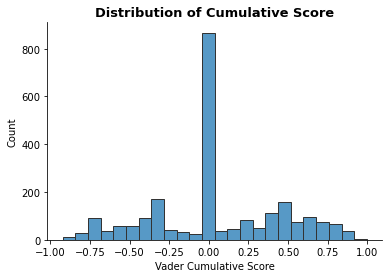

In [29]:
analyzer = SentimentIntensityAnalyzer()
sports_data['vader-sentiment'] = sports_data['tweet'].apply(lambda x: analyzer.polarity_scores(x))
sports_data['vader-pos'] = sports_data['vader-sentiment'].apply(lambda x: x['pos'])
sports_data['vader-neu'] = sports_data['vader-sentiment'].apply(lambda x: x['neu'])
sports_data['vader-neg'] = sports_data['vader-sentiment'].apply(lambda x: x['neg'])
sports_data['vader-compound'] = sports_data['vader-sentiment'].apply(lambda x: x['compound'])

sns.histplot(sports_data['vader-compound'], edgecolor='.2')
plt.xlabel('Vader Cumulative Score')
plt.title('Distribution of Cumulative Score', fontweight='bold', fontsize=13)
sns.despine()
plt.show()

In [30]:
sports_filtered = sports_data[sports_data['vader-compound'] >= 0]
sports_filtered.shape

(1698, 7)

In [31]:
clean_tweets = sports_filtered['clean-tweet'].to_list()
nb_topic_pred = list()
svc_topic_pred = list()

for tweet in clean_tweets:
    nb_topic = ref[nb.predict(tfidf_model.transform([tweet]))[0]]
    nb_topic_pred.append(nb_topic)
    
    svc_topic = ref[ovr_svc.predict(tfidf_model.transform([tweet]))[0]]
    svc_topic_pred.append(svc_topic)

In [32]:
nb_series = pd.Series(nb_topic_pred).value_counts()[:3]
nb_series

Sports    1150
Books      112
Travel     104
dtype: int64

In [33]:
svc_series = pd.Series(svc_topic_pred).value_counts()[:3]
svc_series

Sports    1146
Music      144
Gamers      63
dtype: int64

### Youtube Tweets

In [34]:
youtube = pd.read_csv('datasets/twitter-profiles/report_youtube/tweets.csv')
youtube.head()

,Tweet Id,Tweet URL,Tweet Posted Time,Tweet Content,Tweet Type,Client,Retweets received,Likes received,User Id,Name,Username,Verified or Non-Verified,Profile URL,Protected or Not Protected
0,"""1220238435861970944""",https://twitter.com/youtube/status/12202384358...,2020-01-23 06:54:48,"""Lunar New Year is almost here! 🧧🐭\nFind out w...",Tweet,Twitter Media Studio,105,636,"""10228272""","""YouTube""",youtube,Verified,https://twitter.com/youtube,Not Protected
1,"""1220140861486333952""",https://twitter.com/youtube/status/12201408614...,2020-01-23 00:27:05,"""Do it! https://t.co/FK8d5AEfzC""",Tweet,Twitter Web App,180,3651,"""10228272""","""YouTube""",youtube,Verified,https://twitter.com/youtube,Not Protected
2,"""1220133186048389121""",https://twitter.com/youtube/status/12201331860...,2020-01-22 23:56:35,"""@__gvby HI DAD!""",Reply,Twitter Web App,0,4,"""10228272""","""YouTube""",youtube,Verified,https://twitter.com/youtube,Not Protected
3,"""1220114272316878848""",https://twitter.com/youtube/status/12201142723...,2020-01-22 22:41:25,"""@DunkinJy OR do you know everything?""",Reply,Twitter Web App,0,2,"""10228272""","""YouTube""",youtube,Verified,https://twitter.com/youtube,Not Protected
4,"""1220051182338465792""",https://twitter.com/youtube/status/12200511823...,2020-01-22 18:30:43,"""So proud of you @nikkietutorials. 💞 Watch her...",Tweet,Twitter Media Studio,65,795,"""10228272""","""YouTube""",youtube,Verified,https://twitter.com/youtube,Not Protected


In [35]:
youtube = youtube[youtube['Tweet Type'] == 'Tweet']
youtube['clean-tweet'] = youtube['Tweet Content'].map(preprocess)

In [36]:
youtube_data = youtube[['Tweet Content', 'clean-tweet']].rename(columns={'Tweet Content': 'tweet'})

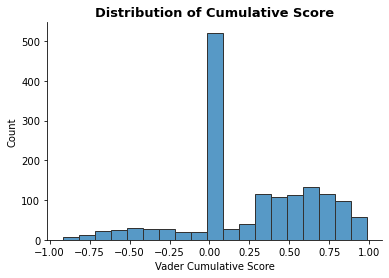

In [37]:
analyzer = SentimentIntensityAnalyzer()
youtube_data['vader-sentiment'] = youtube_data['tweet'].apply(lambda x: analyzer.polarity_scores(x))
youtube_data['vader-pos'] = youtube_data['vader-sentiment'].apply(lambda x: x['pos'])
youtube_data['vader-neu'] = youtube_data['vader-sentiment'].apply(lambda x: x['neu'])
youtube_data['vader-neg'] = youtube_data['vader-sentiment'].apply(lambda x: x['neg'])
youtube_data['vader-compound'] = youtube_data['vader-sentiment'].apply(lambda x: x['compound'])

sns.histplot(youtube_data['vader-compound'], edgecolor='.2')
plt.xlabel('Vader Cumulative Score')
plt.title('Distribution of Cumulative Score', fontweight='bold', fontsize=13)
sns.despine()
plt.show()

In [39]:
youtube_filtered = youtube_data[youtube_data['vader-compound'] >= 0]
youtube_filtered.shape

(1326, 7)

In [84]:
clean_tweets = youtube_filtered['clean-tweet'].to_list()
nb_topic_pred = list()
svc_topic_pred = list()

for tweet in clean_tweets:
    nb_topic = ref[nb.predict(tfidf_model.transform([tweet]))[0]]
    nb_topic_pred.append(nb_topic)
    
    svc_topic = ref[ovr_svc.predict(tfidf_model.transform([tweet]))[0]]
    svc_topic_pred.append(svc_topic)

In [49]:
nb_series = pd.Series(nb_topic_pred).value_counts()[:3]
nb_series

Books     338
Movies    239
Travel    129
dtype: int64

In [85]:
svc_series = pd.Series(svc_topic_pred).value_counts()[:3]
svc_series

Music     203
Movies    184
Nature    177
dtype: int64

In [86]:
youtube_filtered['predicted'] = svc_topic_pred
nature_tweets = youtube_filtered[youtube_filtered['predicted'] == 'Nature']

/opt/anaconda3/envs/lhl-bootcamp/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


### The Ellen Show

In [268]:
def tweet_preprocess(text):
    text=re.sub(r'http\S+', '',text)
    text = re.sub('@[^\s]+','',text)
    text = re.sub('&lt;/?[a-z]+&gt;', '', text)
    text = text.replace('&amp', '&')
    text = re.sub(r"[^\w\s]", "", text)
    text = deEmojify(text)
    text = text.split() #split into list
    #text = [re.sub(r'^https?:\/\/.*[\r\n]*', '', s, flags=re.MULTILINE) for s in text] #remove any links
    #text = [re.sub('@[^\s]+','', s) for s in text] #remove @
    text = [s.lower() for s in text] #convert every character into lowercase
    #text = [re.sub(rf"[{string.punctuation}]", " ", s) for s in text] #remove punctuations
    text = [re.sub(r'[0-9]', ' ', s) for s in text] #remove all digits
    text = ' '.join(text)  #resplits
    text = [s for s in text.split() if len(s) >= 2] #removes words with one word length
    text = [s for s in text if s not in stopwords] #remove all stopwords
    text = ' '.join(spacy_lemmatize(text)) #lemmatize text using spacy and join into a string
    text = ' '.join([s for s in text.split() if len(s) > 2])
    return text


class TweetCategory:

    def __init__(self, model, vectorizer, tweet_data, reference):
        self.data = tweet_data
        self.model = model
        self.vectorizer = vectorizer
        self.ref = reference
        self.analyzer = SentimentIntensityAnalyzer()

    def process_user_tweets(self):
        self.data['clean-tweet'] = self.data['Tweet Content'].map(tweet_preprocess)
        self.data = self.data[['Tweet Content', 'clean-tweet']].rename(columns={'Tweet Content': 'tweet'})

        self.data['vader-sentiment'] = self.data['tweet'].apply(lambda x: self.analyzer.polarity_scores(x))
        self.data['vader-pos'] = self.data['vader-sentiment'].apply(lambda x: x['pos'])
        self.data['vader-neu'] = self.data['vader-sentiment'].apply(lambda x: x['neu'])
        self.data['vader-neg'] = self.data['vader-sentiment'].apply(lambda x: x['neg'])
        self.data['vader-compound'] = self.data['vader-sentiment'].apply(lambda x: x['compound'])


    def predict_topics(self, sentiment_thresh, confidence_thresh):
        self.predict_df = self.data[(self.data['vader-compound'] >= sentiment_thresh) & (self.data['clean-tweet'] != '')]
        
        tweets_transformed = self.vectorizer.transform(self.predict_df['clean-tweet'])
        predicted_category = self.model.predict(tweets_transformed)

        p = np.array(self.model.decision_function(tweets_transformed))
        probability = np.exp(p)/np.sum(np.exp(p), axis=1, keepdims=True)
        probability_list = [max(prob) for prob in probability]

        self.predict_df['predicted'] = predicted_category
        self.predict_df['probability'] = probability_list
        self.predict_df['predicted'] = self.predict_df['predicted'].apply(lambda x: self.ref[x])

        top_categories = self.predict_df[self.predict_df['probability'] >= confidence_thresh]['predicted'].value_counts()[:3]       

        return top_categories

In [269]:
ellen_class = TweetCategory(ovr_svc, tfidf_model, ellen, ref)

In [270]:
ellen_class.process_user_tweets()

In [271]:
predicted = ellen_class.predict_topics(0, 0.2)

In [272]:
predicted

Movies    190
Gamers     62
Nature     46
Name: predicted, dtype: int64

In [255]:
ellen = pd.read_csv('datasets/twitter-profiles/report_theellenshow/tweets.csv')
ellen.head()

,Tweet Id,Tweet URL,Tweet Posted Time,Tweet Content,Tweet Type,Client,Retweets received,Likes received,User Id,Name,Username,Verified or Non-Verified,Profile URL,Protected or Not Protected
0,"""1220160518394015744""",https://twitter.com/theellenshow/status/122016...,2020-01-23 01:45:11,"""Didn’t get to see my show today? You can watc...",Tweet,Twitter Web App,83,1221,"""15846407""","""Ellen DeGeneres""",theellenshow,Verified,https://twitter.com/theellenshow,Not Protected
1,"""1220144486359027712""",https://twitter.com/theellenshow/status/122014...,2020-01-23 00:41:29,"""My staff’s #TheBachelor Recap is really juicy...",Tweet,Twitter Web App,36,808,"""15846407""","""Ellen DeGeneres""",theellenshow,Verified,https://twitter.com/theellenshow,Not Protected
2,"""1220108865972260866""",https://twitter.com/theellenshow/status/122010...,2020-01-22 22:19:56,"""For those of you with your TVs on who are fee...",Tweet,Twitter Media Studio,590,8082,"""15846407""","""Ellen DeGeneres""",theellenshow,Verified,https://twitter.com/theellenshow,Not Protected
3,"""1220093866948214784""",https://twitter.com/theellenshow/status/122009...,2020-01-22 21:20:20,""".@NikkieTutorials is one of the most popular ...",Tweet,Twitter Media Studio,840,7990,"""15846407""","""Ellen DeGeneres""",theellenshow,Verified,https://twitter.com/theellenshow,Not Protected
4,"""1220072534076346369""",https://twitter.com/theellenshow/status/122007...,2020-01-22 19:55:34,"""For a lot of my staff, the 3-day weekend real...",Tweet,Twitter Media Studio,153,1813,"""15846407""","""Ellen DeGeneres""",theellenshow,Verified,https://twitter.com/theellenshow,Not Protected


In [53]:
ellen = ellen[ellen['Tweet Type'] == 'Tweet']
ellen['clean-tweet'] = ellen['Tweet Content'].map(preprocess)

In [61]:
ellen_data = ellen[['Tweet Content', 'clean-tweet']].rename(columns={'Tweet Content': 'tweet'})

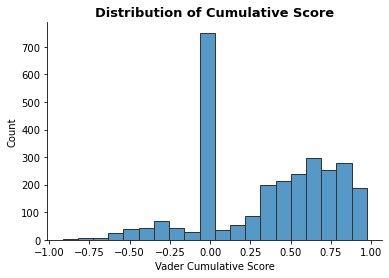

In [63]:
analyzer = SentimentIntensityAnalyzer()
ellen_data['vader-sentiment'] = ellen_data['tweet'].apply(lambda x: analyzer.polarity_scores(x))
ellen_data['vader-pos'] = ellen_data['vader-sentiment'].apply(lambda x: x['pos'])
ellen_data['vader-neu'] = ellen_data['vader-sentiment'].apply(lambda x: x['neu'])
ellen_data['vader-neg'] = ellen_data['vader-sentiment'].apply(lambda x: x['neg'])
ellen_data['vader-compound'] = ellen_data['vader-sentiment'].apply(lambda x: x['compound'])

sns.histplot(ellen_data['vader-compound'], edgecolor='.2')
plt.xlabel('Vader Cumulative Score')
plt.title('Distribution of Cumulative Score', fontweight='bold', fontsize=13)
sns.despine()
plt.show()

In [64]:
ellen_filtered = ellen_data[ellen_data['vader-compound'] >= 0]
ellen_filtered.shape

(2577, 7)

In [249]:
trial = tfidf_model.transform(ellen_filtered['clean-tweet'])
ovr_svc.predict(trial)
p = np.array(ovr_svc.decision_function(trial))
prob = np.exp(p)/np.sum(np.exp(p),axis=1, keepdims=True)
test = list()
for i in prob:
    test.append(max(i))

In [230]:
clean_tweets = ellen_filtered[ellen_filtered['clean-tweet'] != '']['clean-tweet'].to_list()
nb_topic_pred = list()
svc_topic_pred = list()
svc_prob = list()

for tweet in clean_tweets:
    nb_topic = ref[nb.predict(tfidf_model.transform([tweet]))[0]]
    nb_topic_pred.append(nb_topic)
    
    svc_topic = ref[ovr_svc.predict(tfidf_model.transform([tweet]))[0]]
    svc_topic_pred.append(svc_topic)
    p = np.array(ovr_svc.decision_function(tfidf_model.transform([tweet])))
    prob = max(np.exp(p)/np.sum(np.exp(p),axis=1, keepdims=True)[0])
    svc_prob.append(max(prob))

In [67]:
nb_series = pd.Series(nb_topic_pred).value_counts()[:3]
nb_series

Books      790
Movies     564
Alcohol    229
dtype: int64

In [210]:
ellen_filtered = ellen_filtered[ellen_filtered['clean-tweet'] != '']
ellen_filtered['predicted'] = svc_topic_pred
ellen_filtered['prob'] = svc_prob

In [68]:
svc_series = pd.Series(svc_topic_pred).value_counts()[:3]
svc_series

Movies    540
Music     308
Gamers    226
dtype: int64

In [214]:
test = ellen_filtered[ellen_filtered['prob'] >= 0.2]['predicted'].value_counts()

In [221]:
ellen_filtered[(ellen_filtered['prob'] >= 0.2) & (ellen_filtered['predicted'] == 'Nature')]['tweet'].to_list()

['".@IAmJamieFoxx might be the most entertaining person on Earth. https://t.co/Ya7snyglQ9"',
 '"Male students are gonna need a lot more than a note to grow a baby, May-Lin. Bye-bye. #KnoworGO #GameofGames"',
 '"Happy birthday, @GretaThunberg! Thanks for fighting climate change, no matter who stands in your way."',
 '"Go play the Dolittle version of Animals Gone Wild in @HeadsUp! #ThanksSponsor https://t.co/CzXs89IuhB https://t.co/P1tPGbZpzw"',
 '".@OfficialKat really enjoys her cat. https://t.co/UXfuir5TyL"',
 '"We now have a rescue fly. https://t.co/cCap3ZQ6y6"',
 '"Now is your chance to save baby elephants. Here’s how. @HSIAfrica #BeKindToElephants https://t.co/C3ofNYdQoR"',
 '"It’s #CatWeek! The cat\'s out of the bag. And in the bucket. #EDbyPetSmart https://t.co/4FjmIugG7o"',
 '"Cats are wonderful creatures, even if they sometimes try to destroy your life. If you have a photo of a cat-astrophe, send it to me! https://t.co/B7OugPY1nV"',
 '".@JohnCena’s fashion inspiration is gonna m

In [82]:
game_tweets = ellen_filtered[ellen_filtered['predicted'] == 'Gamers']['tweet'].to_list()

### Bill Gates

In [114]:
bill = pd.read_csv('datasets/twitter-profiles/report_billgates/tweets.csv')
bill.head(5)

,Tweet Id,Tweet URL,Tweet Posted Time,Tweet Content,Tweet Type,Client,Retweets received,Likes received,User Id,Name,Username,Verified or Non-Verified,Profile URL,Protected or Not Protected
0,"""1220006544789532678""",https://twitter.com/billgates/status/122000654...,2020-01-22 15:33:21,"""@gavi There are still too many children—many ...",Reply,Twitter Web App,168,1139,"""50393960""","""Bill Gates""",billgates,Verified,https://twitter.com/billgates,Not Protected
1,"""1220006293282230277""",https://twitter.com/billgates/status/122000629...,2020-01-22 15:32:21,"""For twenty years, @gavi has worked to ensure ...",Tweet,Twitter Web App,272,2366,"""50393960""","""Bill Gates""",billgates,Verified,https://twitter.com/billgates,Not Protected
2,"""1219750261268209664""",https://twitter.com/billgates/status/121975026...,2020-01-21 22:34:58,"""I had a fascinating conversation with Vaclav ...",Tweet,Twitter Media Studio,650,4008,"""50393960""","""Bill Gates""",billgates,Verified,https://twitter.com/billgates,Not Protected
3,"""1218240511137370112""",https://twitter.com/billgates/status/121824051...,2020-01-17 18:35:46,"""It's great to see Microsoft's leadership in t...",Tweet,Twitter Web App,1280,10820,"""50393960""","""Bill Gates""",billgates,Verified,https://twitter.com/billgates,Not Protected
4,"""1217863316548116480""",https://twitter.com/billgates/status/121786331...,2020-01-16 17:36:56,"""These global health heroes have helped Bangla...",Tweet,Twitter Media Studio,1082,3549,"""50393960""","""Bill Gates""",billgates,Verified,https://twitter.com/billgates,Not Protected


In [115]:
bill['clean-tweet'] = bill['Tweet Content'].map(preprocess)

In [116]:
bill_data = bill[['Tweet Content', 'clean-tweet']].rename(columns={'Tweet Content': 'tweet'})

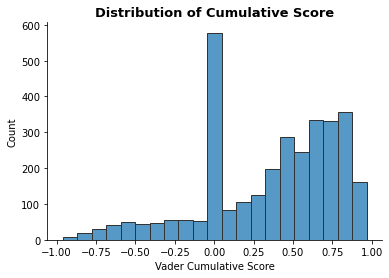

In [117]:
analyzer = SentimentIntensityAnalyzer()
bill_data['vader-sentiment'] = bill_data['tweet'].apply(lambda x: analyzer.polarity_scores(x))
bill_data['vader-pos'] = bill_data['vader-sentiment'].apply(lambda x: x['pos'])
bill_data['vader-neu'] = bill_data['vader-sentiment'].apply(lambda x: x['neu'])
bill_data['vader-neg'] = bill_data['vader-sentiment'].apply(lambda x: x['neg'])
bill_data['vader-compound'] = bill_data['vader-sentiment'].apply(lambda x: x['compound'])

sns.histplot(bill_data['vader-compound'], edgecolor='.2')
plt.xlabel('Vader Cumulative Score')
plt.title('Distribution of Cumulative Score', fontweight='bold', fontsize=13)
sns.despine()
plt.show()

In [118]:
bill_filtered = bill_data[bill_data['vader-compound'] >= 0]
bill_filtered.shape

(2788, 7)

In [119]:
clean_tweets = bill_filtered['clean-tweet'].to_list()
nb_topic_pred = list()
svc_topic_pred = list()

for tweet in clean_tweets:
    nb_topic = ref[nb.predict(tfidf_model.transform([tweet]))[0]]
    nb_topic_pred.append(nb_topic)
    
    svc_topic = ref[ovr_svc.predict(tfidf_model.transform([tweet]))[0]]
    svc_topic_pred.append(svc_topic)

In [121]:
svc_topic_pred[:20]

['Art',
 'Nature',
 'Nature',
 'Nature',
 'Nature',
 'Sports',
 'Nature',
 'Nature',
 'Self-care',
 'Business',
 'Books',
 'Sports',
 'Self-care',
 'Self-care',
 'Gamers',
 'Books',
 'Books',
 'Books',
 'Electronics/Gadgets',
 'Nature']

In [122]:
svc_series = pd.Series(svc_topic_pred).value_counts()
svc_series

Nature                 479
Self-care              373
Books                  323
Electronics/Gadgets    279
Business               212
Travel                 195
Music                  172
Sports                 164
Gamers                 152
Movies                 128
Coffee                  86
Work                    55
Art                     53
Alcohol                 52
Food                    42
Household               23
dtype: int64

In [124]:
nb_series = pd.Series(nb_topic_pred).value_counts()
nb_series

Books                  1131
Business                360
Travel                  333
Electronics/Gadgets     263
Self-care               184
Nature                  173
Movies                  121
Sports                   64
Gamers                   35
Alcohol                  26
Music                    26
Coffee                   19
Art                      17
Food                     15
Work                     14
Household                 7
dtype: int64

### Lebron James

In [126]:
lebron = pd.read_csv('datasets/twitter-profiles/report_kingjames/tweets.csv')
lebron.head(5)

,Tweet Id,Tweet URL,Tweet Posted Time,Tweet Content,Tweet Type,Client,Retweets received,Likes received,User Id,Name,Username,Verified or Non-Verified,Profile URL,Protected or Not Protected
0,"""1219997728480153600""",https://twitter.com/kingjames/status/121999772...,2020-01-22 14:58:19,"""Y’all know I love this city. Was great to be ...",Tweet,Twitter for iPhone,1378,15014,"""23083404""","""LeBron James""",kingjames,Verified,https://twitter.com/kingjames,Not Protected
1,"""1219398135698554882""",https://twitter.com/kingjames/status/121939813...,2020-01-20 23:15:45,"""Hating has no age limit! 🤦🏾‍♂️. #JamesGang is...",Tweet,Twitter for iPhone,23430,165848,"""23083404""","""LeBron James""",kingjames,Verified,https://twitter.com/kingjames,Not Protected
2,"""1218770028499210240""",https://twitter.com/kingjames/status/121877002...,2020-01-19 05:39:53,"""Welcome back Champ!! @TheNotoriousMMA. 🙏🏾💪🏾""",Tweet,Twitter for iPhone,33026,224869,"""23083404""","""LeBron James""",kingjames,Verified,https://twitter.com/kingjames,Not Protected
3,"""1218274115921928193""",https://twitter.com/kingjames/status/121827411...,2020-01-17 20:49:18,"""Trailblazing right along!! Let’s Go Boys! 🙏🏾💪...",Tweet,Twitter for iPhone,928,12521,"""23083404""","""LeBron James""",kingjames,Verified,https://twitter.com/kingjames,Not Protected
4,"""1217598936342507523""",https://twitter.com/ipromiseschool/status/1217...,2020-01-16 00:06:22,"""From a “petting zoo” filled with instruments ...",Retweet,Twitter for iPhone,75,638,"""1019672184929902592""","""I PROMISE School""",ipromiseschool,Verified,https://twitter.com/ipromiseschool,Not Protected


In [127]:
lebron['clean-tweet'] = lebron['Tweet Content'].map(preprocess)

In [128]:
lebron_data = lebron[['Tweet Content', 'clean-tweet']].rename(columns={'Tweet Content': 'tweet'})

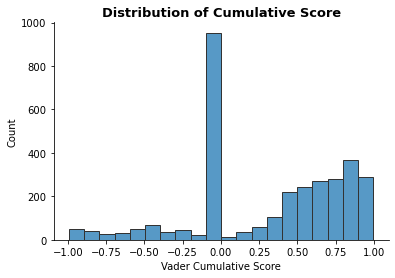

In [129]:
analyzer = SentimentIntensityAnalyzer()
lebron_data['vader-sentiment'] = lebron_data['tweet'].apply(lambda x: analyzer.polarity_scores(x))
lebron_data['vader-pos'] = lebron_data['vader-sentiment'].apply(lambda x: x['pos'])
lebron_data['vader-neu'] = lebron_data['vader-sentiment'].apply(lambda x: x['neu'])
lebron_data['vader-neg'] = lebron_data['vader-sentiment'].apply(lambda x: x['neg'])
lebron_data['vader-compound'] = lebron_data['vader-sentiment'].apply(lambda x: x['compound'])

sns.histplot(lebron_data['vader-compound'], edgecolor='.2')
plt.xlabel('Vader Cumulative Score')
plt.title('Distribution of Cumulative Score', fontweight='bold', fontsize=13)
sns.despine()
plt.show()

In [131]:
lebron_filtered = lebron_data[lebron_data['vader-compound'] >= 0]
lebron_filtered.shape

(2820, 7)

In [201]:
clean_tweets = lebron_filtered[lebron_filtered['clean-tweet'] != '']['clean-tweet'].to_list()
nb_topic_pred = list()
svc_topic_pred = list()
svc_prob = list()

for tweet in clean_tweets:
    nb_topic = ref[nb.predict(tfidf_model.transform([tweet]))[0]]
    nb_topic_pred.append(nb_topic)
    
    svc_topic = ref[ovr_svc.predict(tfidf_model.transform([tweet]))[0]]
    svc_topic_pred.append(svc_topic)
    p = np.array(ovr_svc.decision_function(tfidf_model.transform([tweet])))
    prob = max(np.exp(p)/np.sum(np.exp(p),axis=1, keepdims=True)[0])
    svc_prob.append(max(prob))

In [202]:
svc_series = pd.Series(svc_topic_pred).value_counts()[:3]
svc_series

Sports    513
Music     434
Movies    301
dtype: int64

In [204]:
lebron_filtered = lebron_filtered[lebron_filtered['clean-tweet'] != '']
lebron_filtered['predicted'] = svc_topic_pred
lebron_filtered['prob'] = svc_prob

In [207]:
lebron_filtered[lebron_filtered['prob'] >= 0.2]['predicted'].value_counts()

Sports                 121
Movies                  70
Gamers                  47
Music                   35
Self-care               19
Food                    15
Alcohol                  8
Art                      8
Nature                   7
Travel                   6
Coffee                   5
Books                    4
Household                4
Business                 3
Work                     3
Electronics/Gadgets      2
Name: predicted, dtype: int64

In [151]:
#lebron_filtered[lebron_filtered['prediction'] == 'Music']['tweet'].to_list()

### NASA Tweets

In [154]:
nasa = pd.read_csv('datasets/twitter-profiles/report_nasa/tweets.csv')
nasa.head(5)

,Tweet Id,Tweet URL,Tweet Posted Time,Tweet Content,Tweet Type,Client,Retweets received,Likes received,User Id,Name,Username,Verified or Non-Verified,Profile URL,Protected or Not Protected
0,"""1220149150765002752""",https://twitter.com/nasa/status/12201491507650...,2020-01-23 01:00:01,"""Burn scars left by wildfires in southeastern ...",Tweet,Sprinklr,312,1192,"""11348282""","""NASA""",nasa,Verified,https://twitter.com/nasa,Not Protected
1,"""1220126500843814912""",https://twitter.com/nasa/status/12201265008438...,2020-01-22 23:30:01,"""The search is on! Are you:\n\n☑️Curious about...",Tweet,Sprinklr,170,1098,"""11348282""","""NASA""",nasa,Verified,https://twitter.com/nasa,Not Protected
2,"""1220124092336082946""",https://twitter.com/jimbridenstine/status/1220...,2020-01-22 23:20:27,"""The team has successfully lowered the @NASA_S...",Retweet,Twitter Web App,304,2107,"""243418245""","""Jim Bridenstine""",jimbridenstine,Verified,https://twitter.com/jimbridenstine,Not Protected
3,"""1220107625980973056""",https://twitter.com/nasa/status/12201076259809...,2020-01-22 22:15:01,"""To help return astronauts to the Moon, our #A...",Tweet,Sprinklr,454,2888,"""11348282""","""NASA""",nasa,Verified,https://twitter.com/nasa,Not Protected
4,"""1220092526738247680""",https://twitter.com/nasa/status/12200925267382...,2020-01-22 21:15:01,"""The legacy of @NASASpitzer will live on! Afte...",Tweet,Sprinklr,662,3578,"""11348282""","""NASA""",nasa,Verified,https://twitter.com/nasa,Not Protected


In [155]:
nasa['clean-tweet'] = nasa['Tweet Content'].map(preprocess)

In [156]:
nasa_data = nasa[['Tweet Content', 'clean-tweet']].rename(columns={'Tweet Content': 'tweet'})

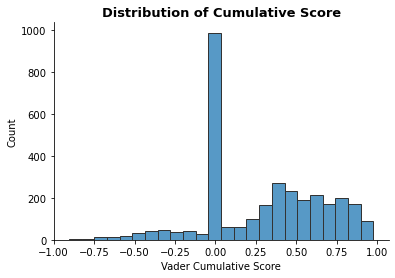

In [161]:
analyzer = SentimentIntensityAnalyzer()
nasa_data['vader-sentiment'] = nasa_data['tweet'].apply(lambda x: analyzer.polarity_scores(x))
nasa_data['vader-pos'] = nasa_data['vader-sentiment'].apply(lambda x: x['pos'])
nasa_data['vader-neu'] = nasa_data['vader-sentiment'].apply(lambda x: x['neu'])
nasa_data['vader-neg'] = nasa_data['vader-sentiment'].apply(lambda x: x['neg'])
nasa_data['vader-compound'] = nasa_data['vader-sentiment'].apply(lambda x: x['compound'])

sns.histplot(nasa_data['vader-compound'], edgecolor='.2')
plt.xlabel('Vader Cumulative Score')
plt.title('Distribution of Cumulative Score', fontweight='bold', fontsize=13)
sns.despine()
plt.show()

In [162]:
nasa_filtered = nasa_data[nasa_data['vader-compound'] >= 0]
nasa_filtered.shape

(2906, 7)

In [182]:
import numpy as np
clean_tweets = nasa_filtered[nasa_filtered['clean-tweet'] != '']['clean-tweet'].to_list()
nb_topic_pred = list()
svc_topic_pred = list()
svc_prob = list()

for tweet in clean_tweets:
    nb_topic = ref[nb.predict(tfidf_model.transform([tweet]))[0]]
    nb_topic_pred.append(nb_topic)
    
    svc_topic = ref[ovr_svc.predict(tfidf_model.transform([tweet]))[0]]
    svc_topic_pred.append(svc_topic)
    p = np.array(ovr_svc.decision_function(tfidf_model.transform([tweet])))
    prob = max(np.exp(p)/np.sum(np.exp(p),axis=1, keepdims=True)[0])
    svc_prob.append(max(prob))

In [183]:
svc_series = pd.Series(svc_topic_pred).value_counts()[:3]
svc_series

Electronics/Gadgets    848
Nature                 520
Gamers                 244
dtype: int64

In [169]:
nasa_filtered = nasa_filtered[nasa_filtered['clean-tweet'] != '']

In [184]:
nasa_filtered['predicted'] = svc_topic_pred
nasa_filtered['prob'] = svc_prob

In [185]:
nasa_filtered[nasa_filtered['predicted'] == 'Gamers']

,tweet,clean-tweet,vader-sentiment,vader-pos,vader-neu,vader-neg,vader-compound,predicted,prob
5,"""Live now! Join us to celebrate @NASASpitzer b...",live join celebrate year mission come close ch...,"{'neg': 0.0, 'neu': 0.815, 'pos': 0.185, 'comp...",0.185,0.815,0.000,0.8016,Gamers,0.127311
52,"""Good luck @Astro_Christina and @Astro_Jessica...",good luck lot people work behind scene support...,"{'neg': 0.091, 'neu': 0.626, 'pos': 0.283, 'co...",0.283,0.626,0.091,0.8585,Gamers,0.221141
59,"""Exciting weekend! Had fun dry-running @SpaceX...",exciting weekend fun dryrunne crew dragon prel...,"{'neg': 0.0, 'neu': 0.565, 'pos': 0.435, 'comp...",0.435,0.565,0.000,0.9760,Gamers,0.121956
66,"""LIVE NOW: Hear from mission experts as they t...",live hear mission expert talk inflight abort t...,"{'neg': 0.0, 'neu': 0.955, 'pos': 0.045, 'comp...",0.045,0.955,0.000,0.1280,Gamers,0.111119
76,"""🚀 @SpaceX's In-Flight Abort Test will demonst...",inflight abort test demonstrate crewdragon abi...,"{'neg': 0.05, 'neu': 0.811, 'pos': 0.139, 'com...",0.139,0.811,0.050,0.5574,Gamers,0.149637
...,...,...,...,...,...,...,...,...,...
3145,""".@Astro_DavidS and @AstroHague are ""go"" for c...",capture dragon cargo craft crew use candaarm g...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,Gamers,0.113596
3146,"""Dragon is ~10 meters from @Space_Station. Cap...",dragon meters capture sequence start shortly,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,Gamers,0.103884
3173,"""Success! This morning, @SpaceX’s Dragon space...",success morning dragon spacecraft launch missi...,"{'neg': 0.0, 'neu': 0.815, 'pos': 0.185, 'comp...",0.185,0.815,0.000,0.6800,Gamers,0.126548
3179,"""We are less than 30 minutes away from the lau...",less minute away launch resupply mission weath...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,Gamers,0.117544


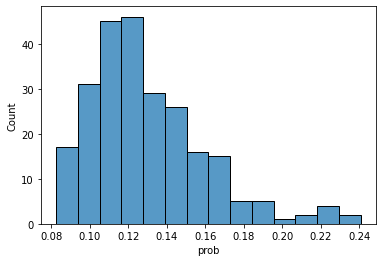

In [192]:
sns.histplot(nasa_filtered[nasa_filtered['predicted'] == 'Gamers']['prob'])
plt.show()

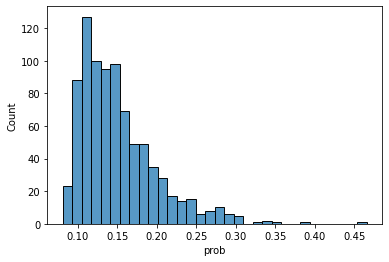

In [195]:
sns.histplot(nasa_filtered[nasa_filtered['predicted'] == 'Electronics/Gadgets']['prob'])
plt.show()

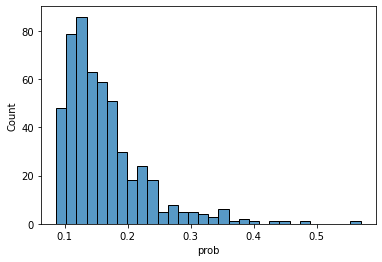

In [196]:
sns.histplot(nasa_filtered[nasa_filtered['predicted'] == 'Nature']['prob'])
plt.show()

In [200]:
nasa_filtered[nasa_filtered['prob'] >= 0.2]['predicted'].value_counts()

Electronics/Gadgets    120
Nature                 104
Music                   17
Travel                  14
Coffee                  14
Movies                  13
Gamers                   8
Sports                   4
Art                      3
Business                 3
Books                    3
Food                     2
Name: predicted, dtype: int64